In [2]:
!pip install rudalle==1.1.3
!pip install ruclip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 4.7 MB/s 
     |████████████████████████████████| 66 kB 4.2 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 1.7 MB 51.4 MB/s 
     |████████████████████████████████| 4.4 MB 40.7 MB/s 
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
     |████████████████████████████████| 45 kB 4.4 MB/s 
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 2.8 MB 49.6 MB/s 
     |████████████████████████████████| 58 kB 7.9 MB/s 
     |████████████████████████████████| 244 kB 60.7 MB/s 
     |████████████████████████████████| 798 kB 57.3 MB/s 
     |████████████████████████████████| 117 kB 73.1 MB/s 
     |████████████████████████████████| 529 kB 69.7 MB/s 
     |████████████████████████████████| 87 kB 8.1 MB/s 
     |████████████████████████████████| 163 k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 580 kB/s 
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.10.1
    Uninstalling huggingface-hub-0.10.1:
      Successfully uninstalled huggingface-hub-0.10.1


  0%|          | 0/398 [00:00<?, ?it/s]

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
x2 --> ready


  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:95: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


  0%|          | 0/1024 [00:00<?, ?it/s]

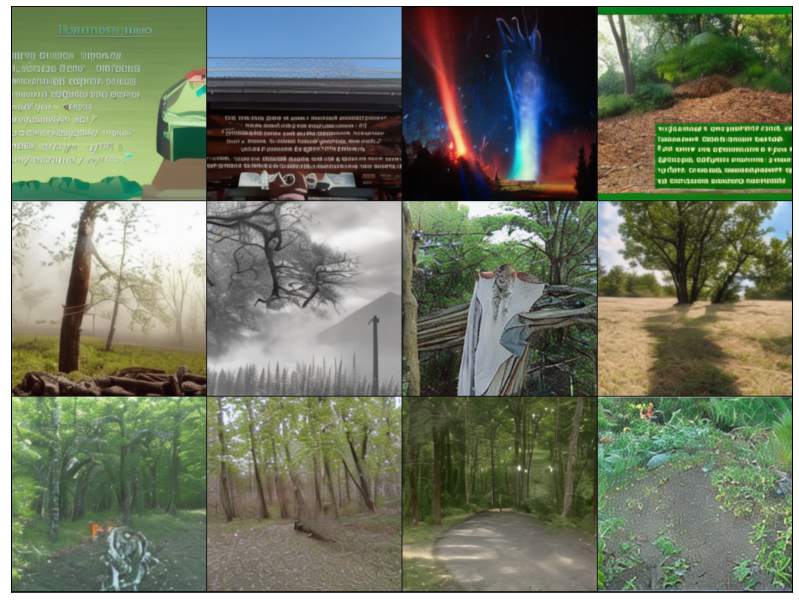

In [18]:
import ruclip
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_ruclip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything
import torch

# prepare models:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=True).to(device)

# pipeline utils:
realesrgan = get_realesrgan('x2', device=device)
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)
clip_predictor = ruclip.Predictor(clip, processor, device, bs=8)
text = 'Старый дуб, весь преображенный, раскинувшись шатром сочной, темной зелени, млел, чуть колыхаясь в лучах вечернего солнца. Ни корявых пальцев, ни болячек, ни старого горя и недоверия — ничего не было видно. Сквозь столетнюю жесткую кору пробились без сучков сочные, молодые листья, так что верить нельзя было, что этот старик произвел их.'

seed_everything(42)
pil_images = []
scores = []
for top_k, top_p, images_num in [
    (2048, 0.995, 12),
]:
    _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, bs=8, top_p=top_p)
    pil_images += _pil_images
    scores += _scores

show(pil_images, 4)


0it [00:00, ?it/s]
12it [00:00, 67.05it/s]


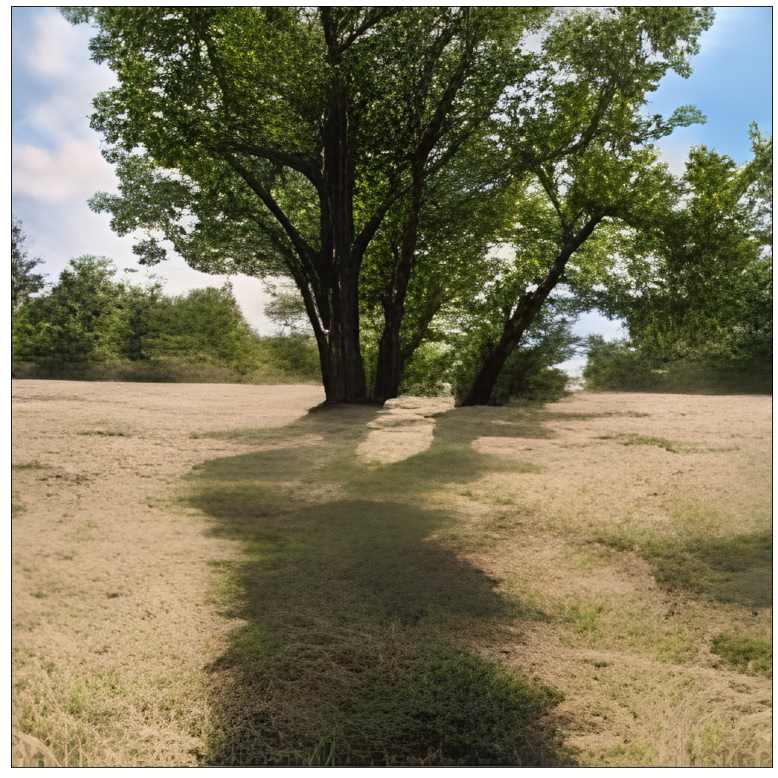

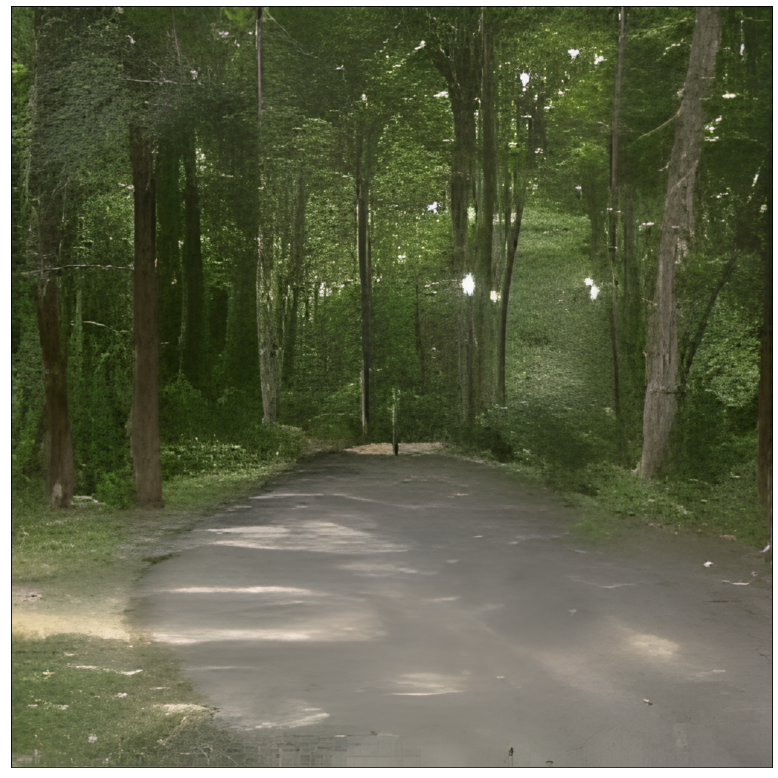

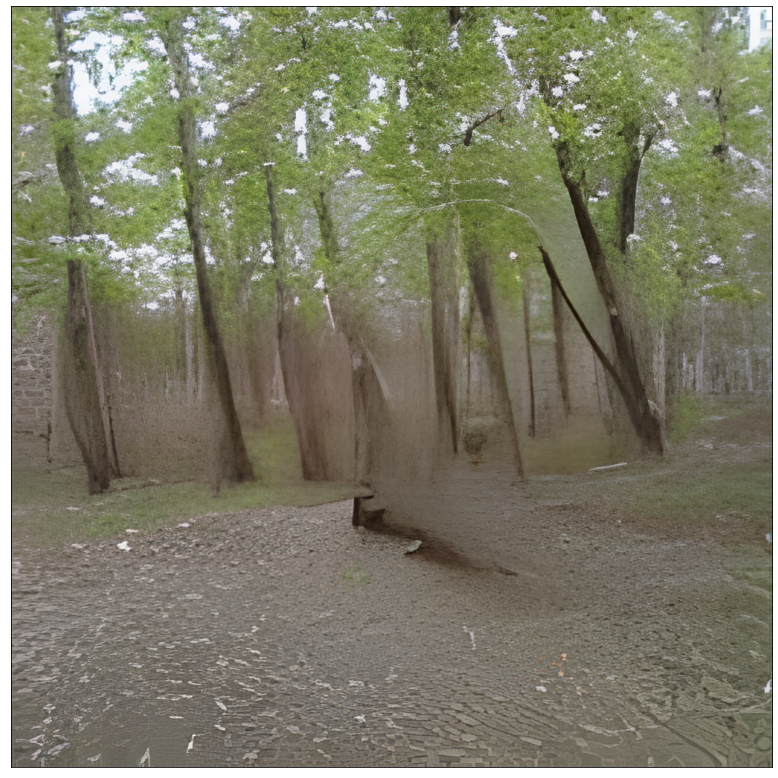

In [21]:
top_count = 3
top_images, clip_scores = cherry_pick_by_ruclip(pil_images, text, clip_predictor, count=top_count)
for i in range(top_count):
    sr_images = super_resolution([top_images[i]], realesrgan)
    show(sr_images, 3)